### Import libraries:

In [1]:
import requests
import time
import re
from bs4 import BeautifulSoup
from itertools import chain
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

### Set a user agent:

In [2]:
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15"}

### Pick artists to scrape:

In [3]:
print("Please choose your artists. If artist's name is composed of 2 or more words, please put a hyphen (-) in between")
artists = []
inputs = artists
while inputs != '0':
    inputs = input('input artists (press 0 when done): ')
    artists.append(inputs)

Please choose your artists. If artist's name is composed of 2 or more words, please put a hyphen (-) in between
input artists (press 0 when done): 2pac
input artists (press 0 when done): mos-def
input artists (press 0 when done): nas
input artists (press 0 when done): notorious-big
input artists (press 0 when done): 0


In [4]:
artists = artists[:-1]

Check what's in the list:

In [5]:
artists

['2pac', 'mos-def', 'nas', 'notorious-big']

### Get lyrics-page to scrape from for each artist in list:

In [149]:
lyrics_links = []
for artist in artists:
    url = 'https://www.metrolyrics.com/' + artist.lower() + '-lyrics.html'
    http_request = requests.get(url, headers=headers)
    pattern = 'http://www.metrolyrics.com/[^\s]+lyrics-' + artist + '\.html'
    lyrics_links.append(re.findall(pattern, http_request.text))

In [157]:
for i in range(len(artists)):
    print(i, len(lyrics_links[i]), artists[i], "example: " + lyrics_links[i][0])

0 79 2pac example: http://www.metrolyrics.com/hit-em-up-lyrics-2pac.html
1 79 mos-def example: http://www.metrolyrics.com/ms-fat-booty-lyrics-mos-def.html
2 79 nas example: http://www.metrolyrics.com/oochie-wally-lyrics-nas.html
3 78 notorious-big example: http://www.metrolyrics.com/juicy-lyrics-notorious-big.html


CAVEAT: some songpages might be empty, i.e. missing lyrics. Only non-empty songs will be appended to the songlist below.

### Scrape the lyrics for each artist song:

In [9]:
songs = []
artist_list = []
# for artist in artists:
for element in lyrics_links:
    for link in element:
        time.sleep(1)                                             # pauses 1 sec
        song_page = requests.get(link, headers=headers)           # requesting each url
        song_soup = BeautifulSoup(song_page.text)                 # soups url-text
        verse = song_soup.body.find_all(class_="verse")           # finds all verses
        songtext = ' '.join([x.text for x in verse])              # loops through verses and extracts text only
        if songtext != '':                                        # checks for empty strings (missing lyrics) before appending
            song_artist = link.split('/')[-1].split('.')[0].split('lyrics-')[-1] #splits the url to label each artist of a (non-empty) song
            artist_list.append(song_artist)                       # creates a list of artist labels
            songs.append(songtext)                                # having all songtexts in a list
            #song_name = link.split('/')[-1].split('.')[0]          # splits the url to label each song
    #        with open(artist + '_lyrics.txt', 'a') as f:                # saves to txt with song-names and empty lines
    #            f.write('\n\n' + songtext + '\n')

In [145]:
print(artist_list) # this list serves as labels for the index of the matrix/dataframe

check the number of scraped songs per artist (must be counter-balanced eventually):

In [11]:
number_of_songs = []
for artist in artists:
    number_of_songs.append(artist_list.count(artist))

In [12]:
number_of_songs, sum(number_of_songs)

([79, 70, 76, 74], 299)

In [13]:
len(songs) #number of songs in list 

299

creating artist labels:

In [14]:
labels = artist_list

# labels = [artists[0]] * number_of_songs[0] + [artists[1]] * number_of_songs[1] + [artists[2]] * number_of_songs[2]

In [15]:
len(labels) #checking for number of labels (should equal number of scraped songs in total):

299

check for correct labels:

In [16]:
# print(labels)

In [17]:
corpus = songs # copying the songs into another list to clean them

In [18]:
len(corpus)

299

### Clean the corpus (with RegEx):

In [95]:
cleaned_corpus = []
for song in corpus:
    song = song.lower()                                     # changes all to lower case
    song = song.replace('\n', ' ')                          # replaces escape-\n with space
    song = re.sub(r"[-()\"#/@;:<>{}=~|.?,\*\!']", "", song) # deletes special characters
    song = re.sub(r"[\[].*?[\]]", "", song)                 # deletes additional info in square brackets
    song = re.sub("\d+", "", song)                          # deletes digits
    cleaned_corpus.append(song)

### Transforming the corpus into a feature matrix (TfidfVectorizer):

In [20]:
tf = TfidfVectorizer()
tf.fit(cleaned_corpus)
tf_vec_corpus = tf.transform(cleaned_corpus)
df = pd.DataFrame(tf_vec_corpus.todense().round(2), index=labels, columns=tf.get_feature_names())

In [21]:
df

,aaaaaahhhhhh,aaahhh,aalike,aarow,aaw,ab,abandoned,abbaccas,abboys,abdomen,...,zhane,zinc,zion,zip,zone,zoo,zoot,zovarax,zulu,zyaire
2pac,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2pac,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2pac,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2pac,0.0,0.0,0.0,0.0,0.29,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2pac,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
notorious-big,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
notorious-big,0.0,0.1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
notorious-big,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
notorious-big,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Defining X and y:

In [22]:
X = df
y = df.index

#### Check whether the data is balanced!

In [23]:
df.index.value_counts(normalize=True) #proportion of songs per artist

2pac             0.264214
nas              0.254181
notorious-big    0.247492
mos-def          0.234114
dtype: float64

In [24]:
df.index.value_counts()

2pac             79
nas              76
notorious-big    74
mos-def          70
dtype: int64

In [25]:
df.isna().values.sum() # check for missing (NaN) values

0

### Dealing with class imbalance (by Undersampling):

RandomUndersampling randomly deletes samples from the majority class(es) to fit number of minority class

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
rus = RandomUnderSampler()

In [28]:
X_rus, y_rus = rus.fit_resample(X, y)

In [29]:
X.shape, X_rus.shape

((299, 12403), (280, 12403))

## Model: Multinomial Naive Bayes

In [30]:
m = MultinomialNB()

In [31]:
m.fit(X_rus, y_rus)

MultinomialNB()

In [219]:
new_input = input("Please enter the verse you want to know the artist of: ")

Please enter the verse you want to know the artist of: harder than yall cause im smarter than yall i know that deep down its got to be bothering yall


In [220]:
new_input

'harder than yall cause im smarter than yall i know that deep down its got to be bothering yall'

In [221]:
#new_input = ' '.join(new_input)
new_input = re.sub(r"[-()\"#/@;:<>{}=~|.?,\*\!']", "", new_input).lower()
new_input = [new_input]

In [222]:
new_input

['harder than yall cause im smarter than yall i know that deep down its got to be bothering yall']

In [223]:
vector_input = tf.transform(new_input)

In [224]:
y_pred = m.predict(vector_input)

In [225]:
y_pred

array(['mos-def'], dtype='<U13')

In [226]:
probability = m.predict_proba(vector_input)

In [227]:
probability

array([[0.20084779, 0.28201535, 0.26150211, 0.25563475]])

In [231]:
print(f"The artist who wrote the verse \"{' '.join(new_input)}\" is most likely {y_pred[0]} with a probability of {round(probability.max(), 2)*100}%")

The artist who wrote the verse "harder than yall cause im smarter than yall i know that deep down its got to be bothering yall" is most likely mos-def with a probability of 28.000000000000004%


## Drawing WordClouds for every artist:

In [43]:
# !pip install wordcloud

In [118]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [135]:
# words to exclude from being shown in the wordcloud:

stopwords = set(STOPWORDS)
stopwords.update(["nigga", "dont", "got", "im", "now", "aint", 
                  "cant", "yall", "back", "niggaz", "let", "ya",
                  "thats", "tha", "one", "make", "take", "come", 
                  "wanna", "want", "yo", "go", "em", "see", "niggas", 
                  "every", "da"])

2pac (287170 words in total)


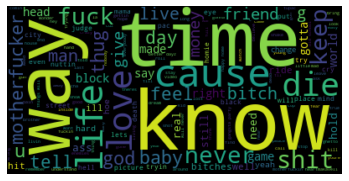

mos-def (215723 words in total)


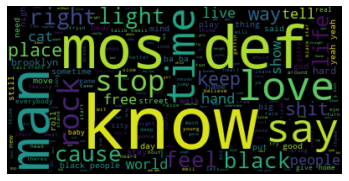

nas (250971 words in total)


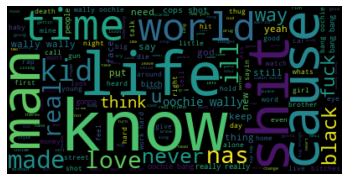

notorious-big (220799 words in total)


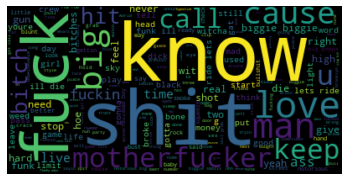

In [136]:
j = 0
for i in range(0, len(artists)):
    text = " ".join(cleaned_corpus[j:number_of_songs[i]+j])        # transforms list of songs per artist into text
    wordcloud = WordCloud(stopwords=stopwords).generate(text)      # generates the wordcloud
    print(artists[i], "(" + str(len(text)) + " words in total)")   # prints the respective artist + number of words
    plt.imshow(wordcloud, interpolation='bilinear')                # plots the cloud
    plt.axis("off")
    plt.show()
    j += number_of_songs[i]